In [1]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import RobustScaler
import os
import subprocess

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

In [3]:
tag = "29_sept"
tag_path = "%s/%s" % (export_folder,tag) 
tag_score_path = "%s/Genetic_score/%s" % (export_folder,tag) 
if not os.path.exists(tag_path): os.mkdir(tag_path)
if not os.path.exists(tag_score_path): os.mkdir(tag_score_path)

# Tags

## 9jun

- factor analysis pour décomposer les scattergrams.
- PLS pour l'ajustement des features et l'estimation par les covariates
- PCT enlevé des covariates, IPF y est bien par contre
- N_PLS_COMPS = 1

## 10jun

idem + :
- phase A & B, 2K cellules / scattergram

## 11jun

idem + :
- PCT gardé comme covariate
- PCA pour les features au lieu de FA
- ajustement des features par PLS mais avec 3 composantes. PLS fittée séparément pour int et sys

jusqu'ici, PEAR1 avait une P-value autour de 0,1... mais avec ça, elle passe à 1E-7. C'est bien, mais il faut pousser encore. Je pense que c'est l'ajustement qui compte beaucoup.

## 11jun_WE

idem + :
- 4 composantes dans la PLS d'ajustement
- On essaie le GWAS sur les _FIB

-> On a PEAR1 ! :) 

## 15jun

idem + :
- normalisé chaque features par sa STD après ajustement, séparément pour train et pour interval

-> Ca marche moins bien...

## 16jun

- enlevé la normalisation
- Remarqué que la covariance est différente entre les variables ajustées de INT et de TRAIN, donc X_int = PCA_train_inv(PCA_int(X_int))

-> Ne marche pas

## 21 juin

- même process, en sélectionnant moins de features (6)

-> PEAR1 est à 4e-7 en PLINK. À suivre

## 21 juin no_pca

- même process, enlevé la PCA

-> 4e-7 mais Beta opposé !?

## 21jun_nopca_3feats

- on ne garde que 3 features

-> 6e-7

## 21jun_3feats_fixedpca

- Problème de PCA résolu : on s'assure que les composantes des PCA post-ajustement sont à peu près les mêmes (on ne vérifiait pas que les signes concordaient...)

-> Marche pas mieux, la PCA n'est pas adaptée

## 22jun_cholesky

- On décorrèle et recorrèle les données avec une Cholesky
- On repasse avec 6 features
- On clippe à -4 - +4
- On remultiplie par les STD post-ajustement -> 1e-7 !

## 22jun_cholesky_3feats

- idem avec 3 features
- Vu qu'il y a peu de features, on utilise juste une régression linéaire à la place de la PLS pour la prédiction des phenotypes. Ca marche mieux (on explique plus de R^2) -> 8e-7

## 22jun_cholesky_3feats_adjust

- en plus, on fait un ajustement à la toute fin du processus

-> 7e-7

## 22jun_3feats_adjust

- No cholesky
- min cohort size = 200

-> 1.7e-7

## 22jun_adjust

- Back to 6 features

-> 2e-8 !!

## 22jun_adj_feats

- Adjust features before fit and prediction
- PLS instead of LR
- back to all features

-> 4.7e-9 !

- Try adding cholesky adjustment, it breaks the p-value. Maybe there's a better way to 

## 25jun_sep_PCA

- Try to use different PCAs for both cohorts

-> 2e-8

## 5_july_gating

- Changed gating
- Kept more platelets per sample
- Kept individuals with PLT count discrepancies
- Same PCA for both cohorts

## 26 july

- Filter upper left corner (kept first rows of .fcs and .116 files)
- adjust STD of scatter signal -> marche pas

## 27 july

-> Ce qui marche le mieux est l'ajustement à la toute fin. Voir si prendre les données de scatter ajustées aide.
-> Dernier truc à explorer : time_of_the_day x machine & regarder les cohortes qui n'ont pas un bon p

# Matching tables

In [81]:
matching = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVAL_OmicsMap_20200514.csv", sep=",")
has_one_id = ~matching["Affymetrix_QC_bl"].isnull() | ~matching["Affymetrix_QC_24m"].isnull()
matching = matching.loc[has_one_id]
matching["AffyID"] = matching["Affymetrix_QC_bl"]
matching.loc[matching.AffyID.isnull(),"AffyID"] = matching.loc[matching.AffyID.isnull(),"Affymetrix_QC_24m"]

In [82]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


In [83]:
meta = pd.merge(matching,int_phen,left_on="identifier", right_on="identifier")
meta["IID"] = meta["AffyID"].astype(int).astype(str)
meta["FID"] = meta["AffyID"].astype(int).astype(str)

meta["cohort"] = meta.interval

In [84]:
meta.sample(3)

,identifier,Affymetrix_QC_bl,Affymetrix_gwasQC_bl,Affymetrix_QC_24m,Affymetrix_gwasQC_24m,AffyID,machine,day,FileName,SampleNo,...,PDW_fL_bl,MPV_fL_bl,PCT_PCT_bl,IPF_bl,weekday,yearday,hours,IID,FID,cohort
29499,1119868,1.100154e+11,1.100154e+11,NaN,NaN,1.100154e+11,1,2013-04-27,[XN-10^11036][00-13_16][20130427_105755][ ...,INT_116_201200,...,NaN,NaN,NaN,NaN,5,117,10,110015374669,110015374669,M10
2297,1009390,1.100036e+11,1.100036e+11,NaN,NaN,1.100036e+11,1,2014-01-03,[XN-10^11036][00-15_5][20140103_135007][ ...,INT_116_2574500,...,NaN,NaN,NaN,NaN,4,3,13,110003641620,110003641620,M10
1865,1007533,NaN,NaN,1.100102e+11,1.100102e+11,1.100102e+11,1,2014-08-14,[XN-10^11036][00-15_5][20140814_103959][ ...,INT_116_5342000,...,14.5,11.7,0.28,9.1,3,226,10,110010189874,110010189874,M12


In [85]:
meta.cohort.value_counts()

M12    5025
M10    4956
F14    4948
M08    4877
F12    4868
F16    4856
Name: cohort, dtype: int64

In [86]:
meta.in_cohort.value_counts()

BL    16647
24    12883
Name: in_cohort, dtype: int64

In [87]:
meta["cohort_covar"] = 0
for i, c in enumerate(meta["in_cohort"].unique().tolist()):
    meta.loc[meta["in_cohort"] == c,"cohort_covar"] = i
meta["age_covar"] = RobustScaler().fit_transform(meta[["Age"]])
meta["instrument_covar"] = 1*(meta.Instrument == "XN-10^11041")

pcs = pd.read_csv("%s/principal_components/PC.eigenvec" % export_folder,sep="\t")
pcs["IID"] = pcs["IID"].astype(str)

In [88]:
match = int_phen.loc[int_phen.ethnicPulse == "Eng/W/Scot/NI/Brit",["SampleNo","identifier"]]
match["valid_id"] = match["identifier"].astype(int)
print(match.shape)

(30725, 3)


In [89]:
sysmex_features = pd.read_csv("%s/processed/sysmex_features_adjusted.csv" % data_dir,index_col=0)
sys_agesex, int_agesex = get_ages_sex()
agesex = pd.concat((sys_agesex,int_agesex),axis=0)
print(agesex.shape[0])
print(sysmex_features.shape[0])
covar = pd.merge(agesex, sysmex_features,left_index=True,right_index=True,how="inner")
print(covar.shape[0])
covar.sample(3)

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)
32922
30670
30670


,SEX,AGE,PLT,MPV,PCT,PDW,IPF
INT_116_2222100,2,50.6,-0.032382,1.473408,0.852254,0.688750,0.453961
INT_116_4685400,2,32.0,0.775965,-1.244352,0.274689,-1.052643,-1.389695
INT_116_743200,1,49.0,-0.837971,0.915148,-0.595247,1.832537,1.344154


In [90]:
bkps_cohort = pd.read_csv("%s/processed/bkpts_cohorts.csv" % data_dir).set_index("SampleNo")
bkps_cohort.rename(columns={"cohort":"bkps_cohort"},inplace=True)
bkps_cohort["bkps_cohort"] = "BKP_" + bkps_cohort["bkps_cohort"].astype(str)
#covar = pd.merge(covar, pd.get_dummies(bkps_cohort["bkps_cohort"],drop_first=True),left_index=True,right_index=True)
covar = pd.merge(covar, bkps_cohort, left_index=True,right_index=True)

In [91]:
covars = pd.merge(covar,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID","age_covar","cohort_covar","yearday","hours","centre"
                                                                                          ]],
                left_index=True,right_index=True)
for c in ["yearday","hours","centre"]:
    del covars[c]
#covars["summer"] = ((covars["yearday"] > 120) & (covars["yearday"] < 250))*1
covars = pd.merge(covars,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
covars = covars[["FID","IID"] + [c for c in covars.columns if c not in ["IID","FID"]]]
#covars["centre"] = "CENTER_" + covars["centre"].astype(str)
covars = covars.dropna(axis=0,how="any")

#covars["cohort_covar"] = "C_" + covars["cohort_covar"].astype(str)

del covars["AGE"]

In [92]:
covars.head()

,FID,IID,SEX,PLT,MPV,PCT,PDW,IPF,bkps_cohort,age_covar,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,110006795043,110006795043,1,-0.575641,-0.281240,-0.776467,-0.092075,-0.861941,BKP_1,0.544304,...,-0.006143,-0.003414,-0.002550,-0.006617,0.007619,0.000518,-0.005138,-0.001251,-0.001450,-0.000475
1,110004131286,110004131286,2,-0.374141,0.009574,-0.266174,0.313868,0.008987,BKP_1,-0.983122,...,-0.002604,-0.000270,0.007260,-0.000367,0.004252,0.004225,0.002824,-0.006574,0.008446,0.005722
2,110006795026,110006795026,2,-1.746033,0.672005,-1.933972,-0.454671,-0.259819,BKP_1,0.569620,...,0.006994,0.005321,-0.006430,0.002057,-0.001391,-0.005765,-0.005126,-0.006106,-0.001899,-0.011991
3,110004131285,110004131285,1,0.240263,0.069391,0.421008,0.070813,-1.006551,BKP_1,0.143460,...,-0.000951,0.008243,-0.000835,-0.004595,-0.002367,0.006899,0.004903,0.001809,-0.000368,-0.000548
4,110006494505,110006494505,2,1.058560,0.086398,1.450019,0.085383,-0.222381,BKP_1,0.227848,...,-0.001484,0.000059,-0.006912,0.007134,0.001031,0.000255,0.003179,0.004252,0.002089,0.009268


In [93]:
phenotypes = pd.read_csv("%s/processed/predictions.csv" % data_dir,index_col=0)
phenotypes = pd.merge(phenotypes,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID"]],
                left_index=True,right_index=True)
phenotypes = pd.merge(phenotypes,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
phenotypes = phenotypes[["FID","IID"] + [c for c in phenotypes.columns if c not in ["IID","FID"] and "PC" not in c]]
phenotypes = phenotypes.dropna(axis=0,how="any")

In [94]:
features = pd.read_csv("%s/processed/features.csv" % data_dir,index_col=0)
features = pd.merge(features,
                meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID"]],
                left_index=True,right_index=True)
features = pd.merge(features,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
features = features[["FID","IID"] + [c for c in features.columns if c not in ["IID","FID"] and "PC" not in c]]
features = features.dropna(axis=0,how="any")

In [95]:
for c in features.columns:
    if features[c].dtype == float:
        features[c] -= features[c].mean()
        features[c] /= features[c].std()

In [96]:
f_cols = features[[c for c in features.columns[2:] if "_0" not in c]]
pca = PCA(n_components=2,whiten=True).fit(f_cols)
f_t = pca.transform(f_cols)
features[["PC_1","PC_2"]] = f_t
print(pca.explained_variance_ratio_)
pd.DataFrame(data=pca.components_,columns=f_cols.columns).T

[0.85692825 0.09120675]


,0,1
mean_1,0.350956,-0.176447
median_1,0.350314,-0.167826
upper_1,0.352947,-0.204316
lower_1,0.342594,-0.151673
std_1,0.334144,-0.252903
iqr_1,0.335277,-0.270138
ratio_upper,0.273861,0.678340
ratio_lower,0.312991,0.452133
ratio_std,0.339326,0.272851


In [97]:
cov_ids = covars.IID.unique().tolist()
phen_ids = phenotypes.IID.unique().tolist()
covars = covars.loc[covars.IID.isin(phen_ids)].sort_values(by="IID")
phenotypes = phenotypes.loc[phenotypes.IID.isin(cov_ids)].sort_values("IID")
features = features.loc[features.IID.isin(cov_ids)].sort_values("IID")
print(covars.shape)
print(phenotypes.shape)

(27569, 21)
(27569, 17)


In [98]:
for c in covars.columns:
    if covars[c].dtype == float:
        covars[c] -= covars[c].mean()
        covars[c] /= covars[c].std()

In [99]:
for c in phenotypes.columns:
    if phenotypes[c].dtype == float:
        phenotypes[c] -= phenotypes[c].mean()
        phenotypes[c] /= phenotypes[c].std()

In [100]:
for c in features.columns:
    if features[c].dtype == float:
        features[c] -= features[c].mean()
        features[c] /= features[c].std()

In [101]:
phenotypes.to_csv("%s/%s/phenotypes.csv" % (export_folder,tag), index=False,header=True, sep="\t")
features.to_csv("%s/%s/features.csv" % (export_folder,tag), index=False,header=True, sep="\t")
covars_without_bkp_cohort = covars[[c for c in covars.columns if "bkps" not in c]]
covars_without_bkp_cohort.to_csv("%s/%s/covars.csv" % (export_folder,tag), index=False,header=True, sep="\t")

In [102]:
covars_without_bkp_cohort.columns

Index(['FID', 'IID', 'SEX', 'PLT', 'MPV', 'PCT', 'PDW', 'IPF', 'age_covar',
       'cohort_covar', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10'],
      dtype='object')

# Launch GWAS (Plink, only CHR 1, by cohorts)

In [103]:
cohort_files = glob("%s/%s/chr_1_*ADP*.glm.linear" % (export_folder, tag))
print("Deleting %d previous sub-cohort meta analyses" % len(cohort_files)) 
for c in cohort_files:
    os.remove(c)

Deleting 3 previous sub-cohort meta analyses


In [104]:
for cohort in covars.bkps_cohort.unique().tolist():
    
    with open("%s/cohort_fids" % tag_path,"w") as file:
        for FID in covars.loc[covars.bkps_cohort == cohort].FID.unique():
            file.write("%s %s\n" % (FID, FID))
    
    k = 1
    n_splits = 1
    
    command = "/home/hv270/plink2 "

    command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % k
    command += "--glm hide-covar"
    #command += " --keep %s/king-cutoff.king.cutoff.in.id" % export_folder
    command += " --keep %s/cohort_fids" % tag_path
    command += " --extract /home/hv270/pear1"
    command += " --pheno %s/%s/phenotypes.csv" % (export_folder, tag)
    command += " --covar %s/%s/covars.csv" % (export_folder, tag)
    command += " --out %s/%s/chr_%d_%s" % (export_folder, tag,k,cohort)
    command += " --threads %d" % n_splits
    command += " --allow-no-sex"
    command += " --variance-standardize"

    f_name = "/home/hv270/interval_slurm_calls/call_chr_%d.sh" % k
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr_%d\n" % k)
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=0:02:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,k))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()
    print(command)

    #print("Submitting %d" % k)
    #p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    print("Running cohort %s \t with %d donors" % (cohort,(covars.bkps_cohort == cohort).sum()))
    p = subprocess.Popen(command,shell=True)
    p.wait()

/home/hv270/plink2 --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1 --glm hide-covar --keep /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/cohort_fids --extract /home/hv270/pear1 --pheno /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/phenotypes.csv --covar /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/covars.csv --out /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/chr_1_BKP_1 --threads 1 --allow-no-sex --variance-standardize
Running cohort BKP_1 	 with 27569 donors


In [105]:
pheno_cols = ["ADP","ADP_FIB"]
for pheno in pheno_cols:
    cohort_files = sorted(glob("%s/%s/chr_1_*%s.glm.linear" % (export_folder, tag,pheno)))
    print(pheno)
    for f in cohort_files:
        res = pd.read_csv(f,delim_whitespace=True)
        print("%s \t %d \t %.2f \t %.2f" % (f.split("/")[-1], res.OBS_CT.iloc[0], -np.log10(res.P.iloc[0]), res.BETA.iloc[0]))
    #command = "/home/hv270/plink --meta-analysis %s/%s/*BKP_*%s.glm.linear \
    #    + qt no-map weighted-z \
    #    --meta-analysis-snp-field ID \
    #    --meta-analysis-ess-field OBS_CT \
    #    --meta-analysis-p-field P \
    #    --out %s/%s/%s_meta" % (export_folder, tag, pheno, export_folder, tag, pheno)
    #p = subprocess.Popen(command,shell=True)
    #p.wait()
    #print(command)
    #res = pd.read_csv("%s/%s/%s_meta.meta" % (export_folder, tag,pheno),delim_whitespace=True)
    #print(np.log10(res["P(R)"].iloc[0]))
    #print(np.log10(res.P.iloc[0]))

ADP
chr_1_BKP_1.ADP.glm.linear 	 27471 	 10.27 	 -0.10
ADP_FIB
chr_1_BKP_1.ADP_FIB.glm.linear 	 27471 	 10.29 	 -0.10


# GWAS features

In [29]:
for cohort in covars.bkps_cohort.unique().tolist():
    
    with open("%s/cohort_fids" % tag_path,"w") as file:
        for FID in covars.loc[covars.bkps_cohort == cohort].FID.unique():
            file.write("%s %s\n" % (FID, FID))
    
    k = 1
    n_splits = 1
    
    command = "/home/hv270/plink2 "

    command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % k
    command += "--glm hide-covar"
    #command += " --keep %s/king-cutoff.king.cutoff.in.id" % export_folder
    command += " --keep %s/cohort_fids" % tag_path
    command += " --extract /home/hv270/pear1"
    command += " --pheno %s/%s/features.csv" % (export_folder, tag)
    command += " --covar %s/%s/covars.csv" % (export_folder, tag)
    command += " --out %s/%s/chr_%d_%s" % (export_folder, tag,k,cohort)
    command += " --threads %d" % n_splits
    command += " --allow-no-sex"
    command += " --variance-standardize"

    f_name = "/home/hv270/interval_slurm_calls/call_chr_%d.sh" % k
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr_%d\n" % k)
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=0:02:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,k))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()
    print(command)

    #print("Submitting %d" % k)
    #p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    print("Running cohort %s \t with %d donors" % (cohort,(covars.bkps_cohort == cohort).sum()))
    p = subprocess.Popen(command,shell=True)
    p.wait()

/home/hv270/plink2 --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1 --glm hide-covar --keep /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/cohort_fids --extract /home/hv270/pear1 --pheno /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/features.csv --covar /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/covars.csv --out /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/chr_1_BKP_1 --threads 1 --allow-no-sex --variance-standardize
Running cohort BKP_1 	 with 27569 donors


In [30]:
for pheno in features.columns[2:]:
    cohort_files = sorted(glob("%s/%s/chr_1_*%s.glm.linear" % (export_folder, tag,pheno)))
    print(pheno)
    for f in cohort_files:
        res = pd.read_csv(f,delim_whitespace=True)
        print("%s \t %d \t %.2f \t %.2f" % (f.split("/")[-1], res.OBS_CT.iloc[0], -np.log10(res.P.iloc[0]), res.BETA.iloc[0]))

mean_0
chr_1_BKP_1.mean_0.glm.linear 	 27471 	 8.00 	 0.04
mean_1
chr_1_BKP_1.mean_1.glm.linear 	 27471 	 0.05 	 0.00
median_0
chr_1_BKP_1.median_0.glm.linear 	 27471 	 8.82 	 0.05
median_1
chr_1_BKP_1.median_1.glm.linear 	 27471 	 0.05 	 0.00
upper_0
chr_1_BKP_1.upper_0.glm.linear 	 27471 	 4.25 	 0.02
upper_1
chr_1_BKP_1.upper_1.glm.linear 	 27471 	 0.04 	 0.00
lower_0
chr_1_BKP_1.lower_0.glm.linear 	 27471 	 9.60 	 0.06
lower_1
chr_1_BKP_1.lower_1.glm.linear 	 27471 	 0.06 	 0.00
std_0
chr_1_BKP_1.std_0.glm.linear 	 27471 	 1.91 	 -0.01
std_1
chr_1_BKP_1.std_1.glm.linear 	 27471 	 0.05 	 0.00
iqr_0
chr_1_BKP_1.iqr_0.glm.linear 	 27471 	 0.15 	 -0.00
iqr_1
chr_1_BKP_1.iqr_1.glm.linear 	 27471 	 0.09 	 -0.00
ratio_upper
chr_1_BKP_1.ratio_upper.glm.linear 	 27471 	 0.82 	 -0.02
ratio_lower
chr_1_BKP_1.ratio_lower.glm.linear 	 27471 	 0.44 	 -0.01
ratio_std
chr_1_BKP_1.ratio_std.glm.linear 	 27471 	 0.33 	 0.01
PC_1
chr_1_BKP_1.PC_1.glm.linear 	 27471 	 0.03 	 -0.00
PC_2
chr_1_BKP_1.PC_

# Launch GWAS all together

In [240]:
covars.to_csv("%s/%s/covars.csv" % (export_folder,tag), index=False,header=True, sep="\t")

In [241]:
covars.columns

Index(['FID', 'IID', 'SEX', 'PLT', 'MPV', 'PCT', 'PDW', 'IPF', 'bkps_cohort',
       'age_covar', 'cohort_covar', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
       'PC7', 'PC8', 'PC9', 'PC10'],
      dtype='object')

In [243]:
with open("%s/all_fids" % tag_path,"w") as file:
    for FID in covars.FID.unique():
        file.write("%s %s\n" % (FID, FID))

k = 1
n_splits = 1

command = "/home/hv270/plink2 "

command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % k
command += "--glm hide-covar"
#command += " --keep %s/king-cutoff.king.cutoff.in.id" % export_folder
command += " --keep %s/all_fids" % tag_path
command += " --extract /home/hv270/pear1"
command += " --pheno %s/%s/phenotypes.csv" % (export_folder, tag)
command += " --covar %s/%s/covars.csv" % (export_folder, tag)
command += " --out %s/%s/chr_%d_all" % (export_folder, tag,k)
command += " --threads %d" % n_splits
command += " --allow-no-sex"
command += " --variance-standardize"

f_name = "/home/hv270/interval_slurm_calls/call_chr_%d.sh" % k
f = open(f_name,"w+")
f.write("#!/bin/sh\n")

f.write("#SBATCH -J chr_%d\n" % k)
f.write("#SBATCH -A ASTLE-SL2-CPU\n")
f.write("#SBATCH -N 1\n")
f.write("#SBATCH -n %d\n" % n_splits)
#f.write("#SBATCH -c %d\n" % n_splits)
f.write("#SBATCH --time=0:02:00\n")
f.write("#SBATCH -p skylake-himem\n")
f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,k))
f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

f.write(". /etc/profile.d/modules.sh\n")
f.write("module purge\n")
f.write("module load rhel7/default-peta4\n")
f.write(command)
f.close()

#print("Submitting %d" % k)
#p = subprocess.Popen("sbatch %s" % f_name,shell=True)
p = subprocess.Popen(command,shell=True)
p.wait()

0

In [244]:
command

'/home/hv270/plink2 --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1 --glm hide-covar --keep /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/all_fids --extract /home/hv270/pear1 --pheno /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/phenotypes.csv --covar /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/covars.csv --out /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/29_sept/chr_1_all --threads 1 --allow-no-sex --variance-standardize'

In [245]:
res = pd.read_csv("%s/%s/chr_1_all.ADP.glm.linear" % (export_folder, tag),sep="\t")
print(np.log10(res.P.iloc[0]))

-10.6868607272148


# Launch GWAS (BOLT LMM)

In [246]:
n_splits = 16

In [247]:
pheno_cols = ["ADP","CRP","TRAP","PAR4","PAR1"]
#pheno_cols += ["%s_FIB" % p for p in pheno_cols]
print(pheno_cols)

['ADP', 'CRP', 'TRAP', 'PAR4', 'PAR1']


In [248]:
for pheno in pheno_cols:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/%s/phenotypes.csv \
        --phenoCol=%s \
        --covarFile=%s/%s/covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT \
        --qCovarCol=MPV \
        --qCovarCol=PDW \
        --qCovarCol=PCT \
        --qCovarCol=IPF \
        --qCovarCol=age_covar \
        --covarCol=SEX \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/%s/bolt_res_feb_%s \
        --statsFileBgenSnps=%s/%s/bolt_res_bgen_feb_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.4 \
        --lmmForceNonInf \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder, tag,
                            pheno,
                            export_folder, tag,
                            export_folder,
                            tag,
                            pheno,
                            export_folder, tag,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=8:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()

Submitting ADP
Submitting CRP
Submitting TRAP
Submitting PAR4
Submitting PAR1


# Bonus : compare predictions across tags

In [99]:
tag1 = "11jun_WE"
tag2 = "16jun"

In [109]:
preds_1 = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder,tag1),index_col=0, sep="\t")
preds_2 = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder,tag2),index_col=0, sep="\t")

In [110]:
comp = pd.merge(preds_1,preds_2,left_index=True,right_index=True,how="inner",suffixes=("_1","_2"))

Text(0.5, 1.0, 'ADP')

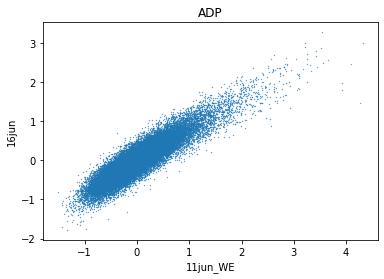

In [111]:
pheno = "ADP"
plt.scatter(comp[pheno+"_1"],comp[pheno+"_2"],s=.1)
plt.xlabel(tag1)
plt.ylabel(tag2)
plt.title(pheno)